In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Github/

/content/drive/MyDrive/Github


In [3]:
!git pull https://github.com/rohit-khoiwal-30/msgmt.git

remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 20 (delta 9), reused 5 (delta 1), pack-reused 0
Unpacking objects: 100% (20/20), done.
From https://github.com/rohit-khoiwal-30/msgmt
 * branch            HEAD       -> FETCH_HEAD
Updating d5ca437..2b5677b
Fast-forward
 bertCONCT.ipynb                          | 681 +------------------------------
 bertEUCL.ipynb                           | 344 +++++++++++-----
 bertTripleLoss.ipynb                     | 328 +++++++++++----
 roc/bertCONCT/New Text Document.txt      |   0
 roc/bertEUCL/New Text Document.txt       |   0
 roc/bertTripleLoss/New Text Document.txt |   0
 roc/useCONCT/New Text Document.txt       |   0
 roc/useEUCL/New Text Document.txt        |   0
 roc/useTripleLoss/New Text Document.txt  |   0
 useCONCT.ipynb                           | 393 +++++++++---------
 useTripleLoss .ipynb                     | 517 +++++++++++++--------

In [4]:
import pandas as pd

In [5]:
df = pd.read_csv("augment_train.csv")
df_test = pd.read_csv("evaluation.csv")

In [6]:
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as tfl
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

try:
    import tensorflow_hub as hub
except ModuleNotFoundError:
    %pip install tensorflow_hub
    import tensorflow_hub as hub
    
try:
    from keras_self_attention import SeqSelfAttention
except ModuleNotFoundError:
    %pip install keras-self-attention
    from keras_self_attention import SeqSelfAttention

import numpy as np
import math as m

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18912 sha256=e2694fadc930eec5083140c56e175c42f44228b05cd671decc57dfb0a62eb1c2
  Stored in directory: /root/.cache/pip/wheels/95/b1/a8/5ee00cc137940b2f6fa198212e8f45d813d0e0d9c3a04035a3
Successfully built keras-self-attention


In [7]:
huburl = "https://tfhub.dev/google/universal-sentence-encoder/4" 
fine_tuned_module_object = hub.load(huburl)

In [8]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    text_batch, reason_batch, y_hat = [], [], []
    all_groups = list(range(in_groups[0].shape[0]))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        text_batch += [in_groups[0][c_idx] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            y_hat += [1]*batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i!=c_idx]) for c_idx in group_idx] 
            b_group_idx = non_group_idx
            y_hat += [0]*batch_halfsize
            
        reason_batch += [in_groups[1][c_idx] for c_idx in b_group_idx]
            
    return np.stack(text_batch, 0), np.stack(reason_batch, 0), np.stack(y_hat, 0)

def siam_gen(in_groups, batch_size = 32):
    while True:
        text_stack, reason_stack, y_hatstack = gen_random_batch(in_groups, batch_size//2)
        yield [text_stack, reason_stack], y_hatstack

In [9]:
def accuracy(y_true, y_pred):
    results = (y_pred >= 0.5).astype(int).squeeze()
    return np.mean([y_true == results])

In [10]:
def encoder1(name):
    inputs = Input(shape=(), dtype=tf.string)

    shared_embedding_layer = hub.KerasLayer(fine_tuned_module_object, trainable=True, name=name)
    embedding_output= shared_embedding_layer(inputs)
    a = tfl.Dropout(0.3)(embedding_output)
    a = tfl.Dense(128, activation="linear", kernel_regularizer=l2(1e-3))(a)
    a = tfl.BatchNormalization()(a)
    a = tfl.Activation('relu')(a)
    a = tfl.Dense(64, activation="linear", kernel_regularizer=l2(1e-3))(a)
    a = tfl.BatchNormalization()(a)
    a = tfl.Activation('relu')(a)
    a = tfl.Dense(32, activation="linear", kernel_regularizer=l2(1e-3))(a)
    a = tfl.BatchNormalization()(a)
    outputs = tfl.Activation('relu')(a)
    
    model = Model(inputs, outputs)
    return model

def encoder2(name):
    inputs = Input(shape=(), dtype=tf.string)

    shared_embedding_layer = hub.KerasLayer(fine_tuned_module_object, trainable=True, name=name)
    embedding_output= shared_embedding_layer(inputs)
    a = tfl.Dropout(0.3)(embedding_output)
    a = tfl.Dense(64, activation="linear", kernel_regularizer=l2(1e-3))(a)
    a = tfl.BatchNormalization()(a)
    a = tfl.Activation('relu')(a)
    a= tfl.Dense(32, activation="linear", kernel_regularizer=l2(1e-3))(a)
    a = tfl.BatchNormalization()(a)
    outputs = tfl.Activation('relu')(a)
    
    model = Model(inputs, outputs)
    return model

In [11]:
def get_model():
    #textEncoder
    inputText = Input(shape=(), dtype=tf.string)
    text_embedd = encoder1("textUSEencoder")(inputText)

    #reasonEncoder
    inputReason = Input(shape=(), dtype=tf.string)
    reason_embedd = encoder2("reasonUSEencoder")(inputReason)

    combined_features = tfl.concatenate([text_embedd, reason_embedd], name = 'merge_features')
    combined_features = tfl.Dense(16, activation = 'linear', kernel_regularizer=l2(1e-3))(combined_features)
    combined_features = tfl.BatchNormalization()(combined_features)
    combined_features = tfl.Activation('relu')(combined_features)
    combined_features = tfl.Dense(4, activation = 'linear', kernel_regularizer=l2(1e-3))(combined_features)
    combined_features = tfl.BatchNormalization()(combined_features)
    combined_features = tfl.Activation('relu')(combined_features)
    combined_features = tfl.Dense(1, activation = 'sigmoid')(combined_features)
    
    model = Model(inputs = [inputText, inputReason], outputs = [combined_features], name="uceModel")
    return model

In [12]:
model = get_model()

In [13]:
model.summary()

Model: "uceModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 model (Functional)             (None, 32)           256874720   ['input_1[0][0]']                
                                                                                                  
 model_1 (Functional)           (None, 32)           256833120   ['input_3[0][0]']                
                                                                                           

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0005), loss = "binary_crossentropy", metrics = [tf.metrics.BinaryAccuracy()])

In [15]:
eval_df = df_test[df_test['label'] == 1]

In [38]:
loss_history = model.fit(siam_gen([df["clean_text"], df["reason"]], 64), 
                         validation_data = siam_gen([eval_df["clean_text"].values, eval_df["reason"].values], 64),
                         steps_per_epoch=50, validation_steps=10, epochs = 30, 
                         verbose = True, use_multiprocessing=True)

Epoch 1/30
50/50 [==============================] - 10s 207ms/step - loss: 0.4480 - binary_accuracy: 0.8525 - val_loss: 0.7241 - val_binary_accuracy: 0.6953
Epoch 2/30
50/50 [==============================] - 11s 211ms/step - loss: 0.4358 - binary_accuracy: 0.8609 - val_loss: 0.7601 - val_binary_accuracy: 0.6812
Epoch 3/30
50/50 [==============================] - 10s 193ms/step - loss: 0.4407 - binary_accuracy: 0.8491 - val_loss: 0.7714 - val_binary_accuracy: 0.6953
Epoch 4/30
50/50 [==============================] - 10s 192ms/step - loss: 0.4166 - binary_accuracy: 0.8700 - val_loss: 0.7954 - val_binary_accuracy: 0.6953
Epoch 5/30
50/50 [==============================] - 10s 191ms/step - loss: 0.4017 - binary_accuracy: 0.8784 - val_loss: 0.7645 - val_binary_accuracy: 0.7078
Epoch 6/30
50/50 [==============================] - 10s 192ms/step - loss: 0.4102 - binary_accuracy: 0.8719 - val_loss: 0.7798 - val_binary_accuracy: 0.7016
Epoch 7/30
50/50 [==============================] - 10s 19

In [39]:
from sklearn.metrics import brier_score_loss as brier_loss
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss

In [40]:
y_preds = model.predict([df['clean_text'], df['reason']])
accuracy(df['label'], y_preds)

0.9660934260275643

In [41]:
y_hat = (y_preds >= 0.5).astype(int)

In [42]:
print("Brier Loss                       : ", brier_loss(df['label'], y_preds))
print("Precision Score                  : ", precision_score(df['label'], y_hat))
print("Recall Score                     : ", recall_score(df['label'], y_hat))
print("F1 Score                         : ", f1_score(df['label'], y_hat))

Brier Loss                       :  0.03407497573880716
Precision Score                  :  1.0
Recall Score                     :  0.9660934260275643
F1 Score                         :  0.9827543424317619


In [43]:
y_preds = model.predict([df_test['clean_text'], df_test['reason']])
accuracy(df_test['label'], y_preds)

0.5881111111111111

In [44]:
y_hat = (y_preds >= 0.5).astype(int)

In [45]:
print("Brier Loss                       : ", brier_loss(df_test['label'], y_preds))
print("Precision Score                  : ", precision_score(df_test['label'], y_hat))
print("Recall Score                     : ", recall_score(df_test['label'], y_hat))
print("F1 Score                         : ", f1_score(df_test['label'], y_hat))
print("Roc AUC Score                    : ", roc_auc_score(df_test['label'], y_preds))
print("BCE Loss                         : ", log_loss(df_test['label'], y_preds))

Brier Loss                       :  0.2988943832393271
Precision Score                  :  0.42155555555555557
Recall Score                     :  0.6321226257914029
F1 Score                         :  0.5057992267697641
Roc AUC Score                    :  0.6393600866166799
BCE Loss                         :  0.9187629147683628


In [46]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr, tpr, _ = roc_curve(df_test['label'], y_preds)
roc_auc = auc(fpr, tpr)

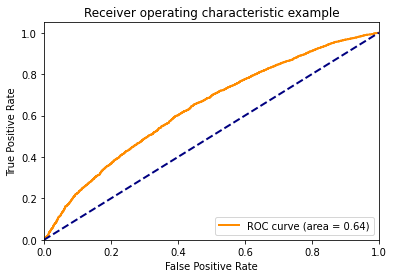

In [47]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [29]:
from numpy import asarray
from numpy import savetxt
# define data
data1 = asarray([fpr])
data2 = asarray([tpr])

# save to csv file
savetxt('roc/bertCONCT/fprdata.csv', data1, delimiter=',')
savetxt('roc/bertCONCT/tprdata.csv', data2, delimiter=',')

In [ ]:
Brier Loss                       :  0.3203359289886762
Precision Score                  :  0.39153871283894154
Recall Score                     :  0.7987337554148617
F1 Score                         :  0.5254850378165077
Roc AUC Score                    :  0.6452798225451215
BCE Loss                         :  0.9062959283337825
